# q3dfit notebook: rest-frame optical, JWST/NIRSpec data of J1652 (SDSSJ165202.64+172852.3) from [Wylezalek et al. 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv221010074W/abstract)

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://q3d.github.io/) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## 1. Initialization

In [1]:
import os.path
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
# Be sure to set the path to q3dfit correctly.
# For instance:
#import sys
#sys.path.append('/Users/jwstuser/q3dfit/')
#import sys
#sys.path.append("../")

### 1.0. Setting up the directory tree

Define the directories in which the data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from q3dfit will be saved. Then download test data.

In [3]:
# Base directory (book-keeping)
volume = 'nirspec-j1652/'
# prefix label for output files
label = 'j1652'
# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
# Output directory
outdir = volume
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Initialization file (q3di.npy) directory
initdir = volume
# Output logfile
logfile = os.path.join(outdir, label+'-fitlog.txt')

Download data from public Box folder:

In [4]:
# make tuples of urls and download filenames
# infile = data cube
infile_tup=('https://rhodes.box.com/shared/static/scu2ydokah2wcqtfsh1tg2y76m75b91q.fits','nirspec-j1652.fits')
# download files; by default don't force overwrite and take first element of output
from q3dfit.nonfit.jnb import download_files
infile = download_files(infile_tup, outdir, force=False)[0]
# add subdirectory to filenames
infile = os.path.join(initdir, infile)

nirspec-j1652.fits already exists, skipping download...


### 1.1. Initializing the fit

The initial parameters of the fit are stored in an object of class `q3din`. Each parameter or attribute of this class controls some aspect of the fit process. We start by instantiating the class. The only required parameters at the outset are the input data cube and label; the label is used for output file naming. 

The default JWST pipeline output has data, variance, and data quality in extensions 1, 2, and 3, respectively. Our processed cube has a different set of extensions, so we specify them here.

In [5]:
from q3dfit.q3din import q3din
q3di = q3din(infile, label, datext=0, varext=1, dqext=2, outdir=outdir, logfile=logfile)

Here's a list of the fit parameters that are automatically set:

In [6]:
q3di.__dict__

{'infile': 'nirspec-j1652/nirspec-j1652.fits',
 'label': 'j1652',
 'argsreadcube': {},
 'cutrange': None,
 'fitrange': None,
 'logfile': 'nirspec-j1652/j1652-fitlog.txt',
 'name': None,
 'outdir': 'nirspec-j1652/',
 'spect_convol': {},
 'vacuum': True,
 'zsys_gas': None,
 'datext': 0,
 'varext': 1,
 'dqext': 2,
 'docontfit': False,
 'dolinefit': False}

### 1.2. Setting up the data and models

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `Cube` class.
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels. While our data is from JWST, the wmap extension has been cut out during processing.
- Microns are the wavelength unit used internally, but `q3dfit` can accept input/output in Å.
- `q3dit` does calculations in f$_\lambda$ space, but assumes input units of MJy/sr, the JWST default. Other input wavelength units can be specified. In this case, the reduced data has been converted to erg/s/cm$^2$/Å. The output flux units will be in erg/s/cm$^2$/$\mu$m.

In [7]:
q3di.argsreadcube = {'wmapext': None,
                     'fluxunit_in': 'erg/s/cm2/Angstrom'}
cube = q3di.load_cube()

Cube: No wavelength units in header; using micron
Cube: No flux units in header; using erg/s/cm2/Angstrom
Cube: No pixel area in header or specified in call; no correction for surface brightness flux units.
Size of data cube: [86, 77, 700]
Wavelength range: [1.81842, 2.09522] micron
Dispersion: 0.00040 micron
Input flux units: erg/s/cm2/Angstrom
Input wave units: micron
Output flux units: erg/s/cm2/micron
Output wave units: micron
NB: q3dfit uses output units for internal calculations.


Let's plot a spaxel near the quasar to see how it looks. The arguments are column and row in unity-offset units. Specifying `radius=0` selects a single spaxel; specifying `radius` > 0 spaxels extracts flux in a circular aperture using `photutils`. This is the region of the galaxy's spectrum containing H$\beta$ and [OIII] 4959, 5007 Å. The flux units are erg/s/cm$^2$/$\mu$m.

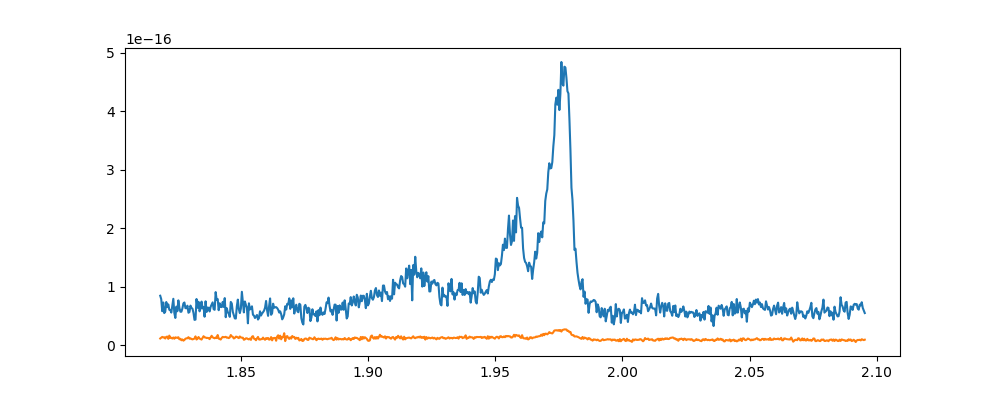

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,4])
spec_test = cube.specextract(48, 48, radius=0)

Due to the fact that JWST/NIRSpec undersamples the PSF, bright point sources create undulations in the spectrum. We apply light smoothing with a circular aperture of radius 2.5 spaxels to account for this, and then plot the result.

In [9]:
cube.convolve(2.5)

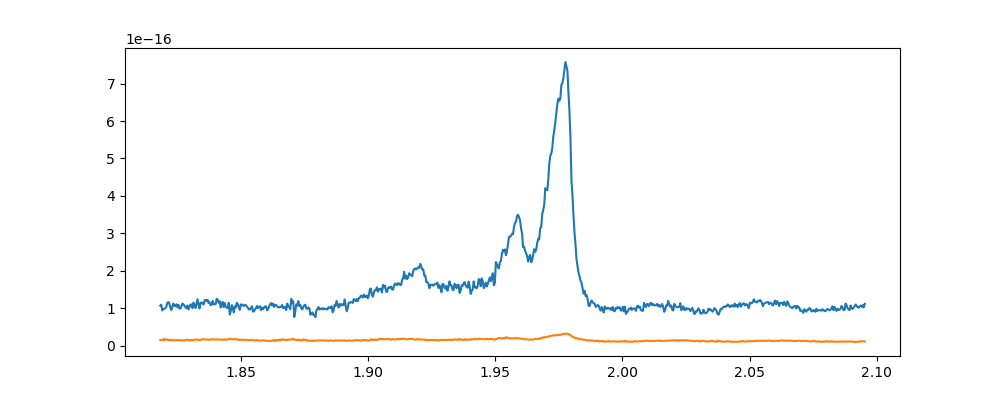

In [10]:
fig = plt.figure(figsize=[10,4])
spec_conv = cube.specextract(48, 48, radius=0)

Now we'll write this convolved cube to disk, and redefine it as our input file for the fit.

In [11]:
cube.writefits(os.path.join(initdir, 'nirspec-j1652-conv.fits'))
q3di.infile = os.path.join(initdir, 'nirspec-j1652-conv.fits')

Output flux units:  erg/s/cm2/micron
Output wave units:  micron


This time, we are going to normalize to minimize numerical issues in the fitting.

In [12]:
q3di.argsreadcube = {'wmapext': None, 
                     'fluxunit_in': 'erg/s/cm2/micron',
                     'fluxnorm': 1e-17}
cube = q3di.load_cube()

Cube: No wavelength units in header; using micron
Cube: No flux units in header; using erg/s/cm2/micron
Cube: No pixel area in header or specified in call; no correction for surface brightness flux units.
Size of data cube: [86, 77, 700]
Wavelength range: [1.81842, 2.09522] micron
Dispersion: 0.00040 micron
Input flux units: erg/s/cm2/micron
Input wave units: micron
Output flux units: erg/s/cm2/micron
Output wave units: micron
NB: q3dfit uses output units for internal calculations.


Let's double-check what we have:

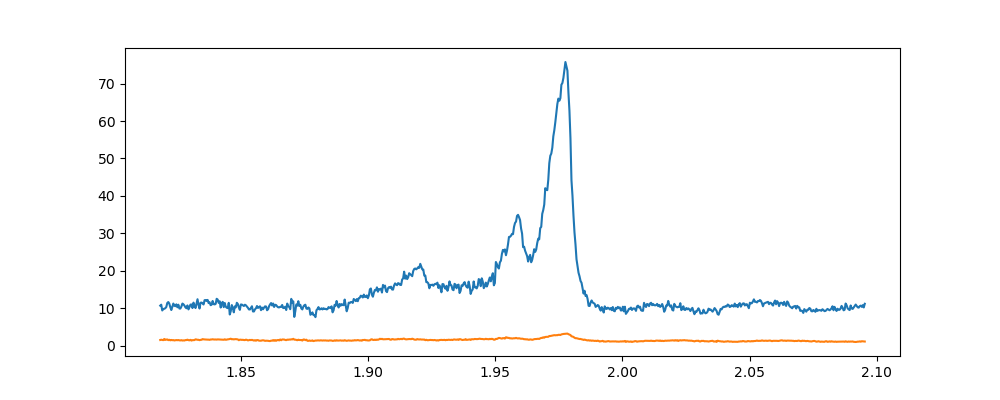

In [13]:
fig = plt.figure(figsize=[10,4])
spec_test = cube.specextract(48, 48, radius=0)

Name and systemic redshift of the galaxy. `zsys_gas` is an input for calculating velocity maps in `q3dpro` and for initializing the arrays of initial guesses below.

In [14]:
q3di.name = 'J1652'
q3di.zsys_gas = 2.9489

Wavelength range over which to fit data. The user can also specify sets of regions to ignore in the fit.

In [15]:
q3di.fitrange = [1.82, 2.09]
#q3di.cutrange = np.array([,])

Create quasar template from the peak spaxel. We normalize so the template flux is around unity.

makeqsotempate: using peak spaxel in white light as center


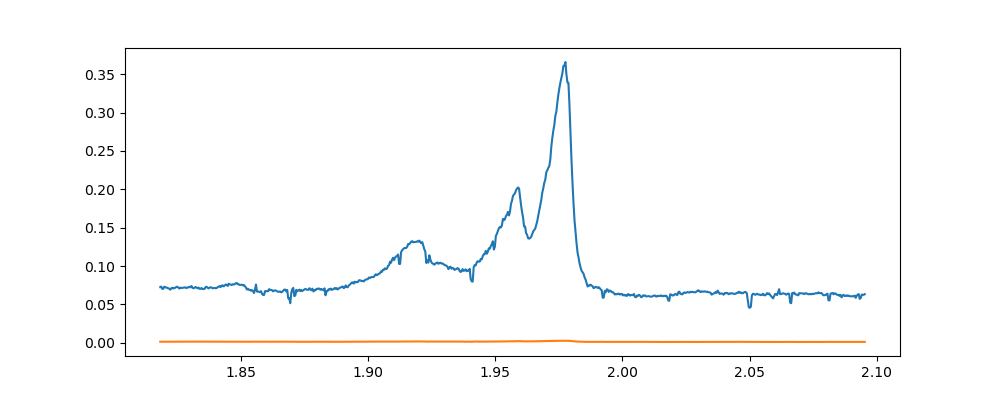

In [16]:
qsotemplate = os.path.join(outdir, 'nirspec-j1652-quasar-template.npy')
fig = plt.figure(figsize=[10,4])
cube.makeqsotemplate(qsotemplate, radius=0., norm=5e3)

### 1.3. Setting up the fitting parameters

#### 1.3.1. Emission-line parameters

What lines do you want to fit? You can choose from the linelists available [here](https://github.com/Q3D/q3dfit/tree/main/q3dfit/data/linelists), or in `q3dfit/data/linelists/`.

In [17]:
lines = ['Hbeta', '[OIII]4959', '[OIII]5007']

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globally, for all spaxels and components, by defining a 2-element array when initializing the fit. The limits can also be set for individual spaxels and components later by defining an (Ncol x Nrow x Ncomp x 2) array, or by modifying the initial array using slicing.

In [18]:
# Global limit
siglim_gas = np.array([40., 2000.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, ncomp, 2))
# siglim_gas[:,:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :,] = array([5.,500.])

This block sets up initial conditions for the emission-line fit to each spaxel. This initialization method adds a number of new attributes to the object. Emission lines are set to a common redshift and velocity dispersion, set to `q3di.zsys_gas` and 50 km/s by default. However, different sets of emission lines can have different velocities and linewidths by specifying different lines to which to tie particular emission lines. Different initial conditions can also be set on a spaxel-by-spaxel and/or line-by-line basis. The default number of velocity components is 1. Here, we change this to 3.

In [19]:
q3di.init_linefit(lines, linetie='[OIII]5007', maxncomp=3, siglim_gas=siglim_gas)
q3di.__dict__.keys()

dict_keys(['infile', 'label', 'argsreadcube', 'cutrange', 'fitrange', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'maxncomp', 'fcnlineinit', 'argslineinit', 'argslinelist', 'argslinefit', 'checkcomp', 'fcncheckcomp', 'argscheckcomp', 'perror_errspecwin', 'perror_residwin', 'perror_useresid', 'linetie', 'linevary', 'ncomp', 'siginit_gas', 'siglim_gas', 'zinit_gas'])

Because of the complexity of these line profiles, we change the default initial conditions. `zinit_gas` and `siginit_gas` are dictionaries of arrays that hold the initial conditions for each line, spaxel, and velocity component.

In [20]:
for i in lines:
    # narrow, redshifted component
    q3di.zinit_gas[i][:,:,2] = 2.959
    # broad, blueshifted component
    q3di.zinit_gas[i][:,:,1] = 2.9489
    q3di.siginit_gas[i][:,:,1] = 500.

The routine `checkcomp` automatically discards components that it deems insignificant after each fit. It does so with both a significance cut on flux, and if the linewidth is too large. If components are removed, the fit is re-run.

The `sigcut` parameter determines the level of the significance cut. `ignore` is a list of lines to ignore when performing the significance cut.

In [21]:
#q3di.checkcomp = False
q3di.argscheckcomp['sigcut'] = 3.
q3di.argscheckcomp['ignore']= ['Hbeta']

##### Line ratio constraints
Lines with ratios fixed by atomic physics have their ratios fixed automatically. Other ratios can have bound constraints applied, or they can be fixed to a particular value. Some density-sensitive ratios have bounds applied; these limits can be found in [this table](/q3dfit/data/linelists/doublets.tbl).

See [the documentation](https://q3dfit.readthedocs.io/stable/q3dfit.html#q3dfit.lineinit.lineinit) for more details.

- `line1`, `line2`, and `comp` are required. `comp` is an array of velocity components (zero-indexed) on which to apply the constraints, one array for each pair of lines.
- `value` is the initial value of `line1`/`line2`. Presently, if `value` is specified for one pair of lines, it must be specified for all. Otherwise, the initial value is determined from the data.
- The ratio can be `fixed` to the initial value. Presently, if `fixed` is defined, it must be set to `True` or `False` for all pairs of line.
- If the ratio is not `fixed`, `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) Presently, if `lower` or `upper` is defined here for one set of lines, it must be defined here for every pair of lines.

In [22]:
# Required columns:
# line1 = ['[NI]5198', '[SII]6716']
# line2 = ['[NI]5200', '[SII]6731']
# comp = np.array([[0], [0]], dtype=np.int32)

# Optional columns:
# value = [1.5, 1.]
# fixed = [True, False]
# lower = []
# upper = []

# Write table
# from astropy.table import QTable
# lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

# q3di.argslineinit['lineratio']=lineratio

##### Spectral resolution convolution

If no convolution is desired: do not set `spect_convol` (or set it to `{}`, or `None`).

If convolution is desired: `spect_convol` is a dictionary with two optional tags.
- `ws_instrum`: This specifies the desired convolution method. The syntax is: `{INSTRUMENT:[GRATING]}`. The values for `INSTRUMENT` and `GRATING` for pre-defined dispersion files should mirror the filename syntax in `q3dfit/data/dispersion_files/`. E.g., for file `jwst_miri_ch1a_disp.fits`, `INSTRUMENT=jwst_miri` and `GRATING=ch1a`. (Case is irrelevant. For convolution with a constant value of spectral resolution [R], Δλ FWHM in [$\mu$m], or velocity in [km/s], set `INSTRUMENT = flat` and `GRATING = ` a string containing `R`, `dlambda`, or `dvel` and the corresponding numerical quantity. More thana one instrument and/or grating can be set.
- `dispdir`: Directory in which to find the dispersion files. If not set, the default `q3dfit` directory is searched.

Examples: 
1. flat R=500: `spect_instrum = {'flat':['R500']}`
2. flat velocity FWHM = 30km/s: `spect_instrum = {'flat':['dvel30']}`
3. flat Δλ FWHM = 4 Å: `spect_instrum = {'flat':['dlambda0.0004']}`
4. JWST NIRSPEC / G140M: `spect_instrum = {'JWST_NIRSPEC':['G140M']}`
5. Spitzer IRS SH+LH: `spect_instrum = {'Spitzer_IRS':['ch1_sh','ch1_lh']}`

Note in the final example that two gratings are set.

In [23]:
q3di.spect_convol['ws_instrum'] = {'JWST_NIRSPEC':['G235H']}

##### Creating convolution files (optional)

To create a dispersion file, use one of the following methods. The second two involve specific subclasses of the dispersion class used for the instrument/grating file or constant dispersion formats 

1. Create a `dispersion` object and use the `dispersion.write()` method. For example:

```
dispEx1 = dispersion()
dispEx1.write('/dispdir/disp.fits', wave=np.linspace(5.,10.,50), type='R', disp=np.full(50, 500.))
```

2. Create a `InstGratDispersion` object to attach instrument and grating information to the object and define the output filename in the `q3dfit` format. Use the `InstGratDispersion.writeInstGrat()` method.

```
dispEx2 = InstGratDispersion(`Keck_ESI`,`echellette`, dispdir=`/dispdir/`)
dispEx2.writeInstGrat(wave=np.linspace(5.,10.,50), type='dvel', disp=np.full(50, 30.))
```

3. Create a `FlatDispersion` object and use the `FlatDispersion.writeFlat()` method. This requires only a single value for the dispersion quantity and also defines the filename automatically.
```
dispEx3 = FlatDispersion(0.0004,`dlambda`,wave=np.linspace(5.,10.,50))
dispEx3.writeFlat(dispdir=`/dispdir/`)
```

##### Options to `lmfit` and `scipy.optimize.least_squares` (or `scipy.optimize.leastsq`, or other optimizer)
`q3dfit` uses the `fit` method of the [`Model` class](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model) of `lmfit` to call [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html), or another method of choice. Both the method and function have options which can be changed in the `q3dfit` call. To do so, add key/value pairs to the `argslinefit` dictionary, which in turn is a keyword of the `q3di` dictionary.

The options to the `fit` method in `lmfit` that can currently be changed are the following:
- `method`: in particular, `leastsq` may be faster than `least_squares`
- `max_nfev`: maximum number of function evaluations before the fit aborts
- `iter_cb`: if this is set to "per_iteration", the value of every model parameter at each function evaluation is printed to `stdout`

Presently, `max_nfev` = [200 x (Nparams+1)] for `least_squares` and [2000 x (Nparams+1)] for `least_sq` by default.

Most parameters of `least_squares`/`leastsq` can be changed in this way, unless they are specifically set by `lmfit`. Examples which have been tested include:
- `x_scale`: jac [least_squares]
- `tr_solver`: lsmr [least_squares]
- `loss`: soft_l1 [least_squares]
- `ftol`, `gtol`, `xtol` [both methods]
- `epsfcn` [leastsq]

In [24]:
q3di.argslinefit = dict()
#q3di.argslinefit['method'] = 'leastsq'
#q3di.argslinefit['iter_cb'] = 'per_iteration'
# As an example, to change the criteria for fit convergence from the defaults of 1.e-8 to 1.e-10:
q3di.argslinefit['ftol'] = 1.e-10
q3di.argslinefit['gtol'] = 1.e-10
q3di.argslinefit['xtol'] = 1.e-10
q3di.argslinefit['x_scale'] = 'jac'
q3di.argslinefit['tr_solver'] = 'lsmr'
# .. and the "suitable step length for the forward- difference approximation of the Jacobian. 
# Normally the actual step length will be sqrt(epsfcn)*x"
#q3di.argslinefit['epsfcn'] = 1.e-15

#### 1.3.2 Continuum parameters

We next initialize the continuum. As part of this, we give it the name of our continuum fitting function. (See Rupke et al. 2017 for more details on the methodology of `q3dfit` when separating a quasar from its host galaxy.)

In [25]:
q3di.init_contfit('fitqsohost')
q3di.__dict__.keys()

dict_keys(['infile', 'label', 'argsreadcube', 'cutrange', 'fitrange', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'maxncomp', 'fcnlineinit', 'argslineinit', 'argslinelist', 'argslinefit', 'checkcomp', 'fcncheckcomp', 'argscheckcomp', 'perror_errspecwin', 'perror_residwin', 'perror_useresid', 'linetie', 'linevary', 'ncomp', 'siginit_gas', 'siglim_gas', 'zinit_gas', 'fcncontfit', 'argscontfit', 'dividecont', 'av_star', 'keepstarz', 'maskwidths', 'maskwidths_def', 'masksig_secondfit', 'nolinemask', 'nomaskran', 'startempfile', 'startempvac', 'siginit_stars', 'zinit_stars'])

`q3dfit` first masks emission lines before fitting. The default mask value is 500 km/s for each velocity component for the first fit. During the second fit, the mask value is set automatically using the best-fit linewidths determined from the first fit.

For this case, the lines are quite broad and we change the default.

In [26]:
q3di.maskwidths_def = 2000.

The continuum fitting parameters specified here are for the case of simultaneous fitting of a stellar and quasar template.
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`.
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`.
- `qsoxdr` = Filename and path of quasar template created earlier with `makeqsotemplate.py`.
- `refit` = Set to `ppxf` to fit (data - quasar) residual with stellar model.
- `blrpar` = Set of initial Gaussian parameters (flux, observed wavelength, sigma in km/s) for fitting empirical scattered-light model (relevant only for narrow set of cases).

In [27]:
q3di.argscontfit['qsoxdr'] = qsotemplate
q3di.argscontfit['qsoord'] = 2
q3di.argscontfit['hostord'] = 2

Optional arguments to `lmfit`. See above for a description in the case of line fits.

In [ ]:
argslmfit = dict()
#argslmfit['method'] = 'leastsq'
argslmfit['ftol'] = 1.e-12
argslmfit['gtol'] = 1.e-12
argslmfit['xtol'] = 1.e-12
argslmfit['x_scale'] = 'jac'
argslmfit['tr_solver'] = 'lsmr'
#argslmfit['epsfcn'] = 1.e-15
q3di.argscontfit['argslmfit'] = argslmfit

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.q3dfit import q3dfit
q3dfot(q3di,cols=cols,rows=rows)</code></pre>
N.B.: When running `q3dfit` using multiple cores (`ncores=N` in the call to `q3df`), the input dictionary has to be specified in this way; i.e., as a string describing the location of this .npy file.

In [ ]:
q3di_npy = 'q3di.npy'
np.save(os.path.join(initdir, q3di_npy), q3di)

## 2. Run fit

Choose columns and rows to fit. Ranges are specified as two-element lists specifying the first and last spaxel.

In [ ]:
cols = 45
rows = 29

Run the fit. Choose `quiet=False` for verbose output. An output object for each spaxel, of class `q3dout`, is saved to a numpy binary file labeled with prefix `q3di['label']` and suffix `_col_row.npy`. See note above on multicore processing.

In [ ]:
from q3dfit.q3df import q3dfit
#q3dfit(q3di,cols=cols,rows=rows, quiet=False)
q3dfit(os.path.join(initdir, q3di_npy),cols=[20, 75],rows=[15, 70],ncores=30)

## 3. Plot fit results

Load the output of a fit.

In [ ]:
cols = 45
rows = 29
from q3dfit.q3dout import load_q3dout
q3do = load_q3dout(q3di, cols, rows)

Set up the line plot parameters using a dictionary.

* `nx`: Number of subplots in the horizontal direction (default = 1)
* `ny`: Number of subplots in the vertical direction (default = 1)
* Required: choose one options for centerting the plot
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame
* `size`: float list of widths in wavelength space of each subplot; if not specified (default = 300 $Å$)
* `IR`: set to `True` to use infrared-style plot

In [ ]:
argsplotline = dict()
argsplotline['nx'] = 2
argsplotline['ny'] = 1
argsplotline['line'] = ['Hbeta', '[OIII]5007']
argsplotline['size'] = [0.05, 0.07]
argsplotline['figsize'] = [10,8]

Run the plot method. The output can be saved to a file by specifying `savefig=True`. A default filename is used, which can be overridden by specifying `outfile=file`. The output file will have the suffix `_lin` attached, so that the actual filename will be "file_lin.png". The file format, and other [pyplot.savefig](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html) options, can be added to the `plotargs` dictionary as, e.g., `'argssavefig': {'format': '.pdf'}`.

In [ ]:
q3do.plot_line(q3di,plotargs=argsplotline)

The continuum plot can be changed by specifying several parameters. In this case, we have chosen to output a linear/linear plot of f$_\lambda$ vs. wavelength.

In [ ]:
argscontplot = dict()
argscontplot['zeroymin'] = True
argscontplot['figsize'] = [10,8]

Run two methods. The first computes the continuum values to plot, and the second does the plotting. Three plots are created: one for the host-only light, one for quasar-only light, and one for the total continuum.

In [ ]:
q3do.sepcontpars(q3di)
q3do.plot_cont(q3di, plotargs=argscontplot)

## 4. Combine fit results from all spaxels

This routine takes all of the spaxels you fit and combines the line- and continuum-fitting results together. The outputs are saved into two files. This example assumes that the spaxels listed here in each dimension have been fit.

In [ ]:
cols = [20, 75]
rows = [15, 70]
from q3dfit.q3dcollect import q3dcollect
q3dcollect(q3di, cols=cols, rows=rows, ignoreres=True, compsortpar='wave')

## 5. Plot science products

These routines take the output of `q3dcollect` and process them further for science output. The `q3dpro` class has methods to make maps of physical quantities.

In [ ]:
from q3dfit.q3dpro import Q3Dpro
# The platescale option helps get the plotting scale right. 
# The nocont option speeds things up by skipping the processing of continuum data.
qpro = Q3Dpro(q3di, platescale=0.025, nocont=True, quiet=False)

In [ ]:
qpro.__dict__

Start by plotting linemaps for [OIII], of both flux and velocity measures. The parameters listed below control the plotting.

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

flxlim = [1e-2,1e1]
ranges = {'Ftot':flxlim,
          'Fci':flxlim,
          'Sig':[100.,850.],
          'v50':[-1000.,1000.],
          'w80':[100.,850.],
          'fluxlog': True}
qpro.make_linemap('[OIII]5007', xyCenter=[45., 43.], fluxlog=True, ranges=ranges, CMAP='inferno', dpi=100)

Map of [OIII]/H$\beta$ for each component, and for the total flux:

In [ ]:
qpro.make_lineratio_map('[OIII]5007', 'Hbeta', vminmax=[0,1], dpi=100)

Map of v50 over the cumulative velocity distribution:

In [ ]:
from q3dfit.q3dpro import OneLineData
o3data = OneLineData(qpro.linedat, '[OIII]5007')
o3data.calc_cvdf(2.9489, [-1e3, 1e3], vstep=5)
o3data.make_cvdf_map(50., velran=[-1e3, 1e3], markcenter=[45., 43.],
                     outfile=True)

Map of W80 over the cumulative velocity distribution:

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[6,4.5])
plt.imshow(o3data.calc_cvdf_vel(90, calc_from_posvel=False).T - o3data.calc_cvdf_vel(10, calc_from_posvel=False).T,
           origin='lower', vmin=50, vmax=1500)
plt.colorbar()
plt.show()